In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Modelado

Cargamos los conjuntos de datos y librerías que se usarán en esta sección:

In [2]:
from utils.paths import crear_funcion_directorio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from utils.modeling import mostrar_podio_MVP
from utils.visualize import plotear_predvsreal
from utils.modeling import metricas_reg
from utils.modeling import calcular_importancia
from joblib import dump
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo los conjuntos de datos
df_data_jugadores_train = pd.read_csv(data_dir("processed", "df_data_jugadores_train.csv"))
X_train = pd.read_csv(data_dir("for_modeling", "X_train.csv"))
y_train = pd.read_csv(data_dir("for_modeling", "y_train.csv"))

## Random Forest

El modelo que hemos decidido utilizar es el **Random Forest**, aquí dejamos algunas razones:

* Capacidad para trabajar con conjuntos de datos **con muchas dimensiones**
* Capacidad para captar **relaciones no lineales** 
* Brinda información sobre la **importancia** de cada feature utilizado para entrenarlo
* Al ser un modelo de ensamble, **tiende a mitigar el problema del sobreajuste**

Antes de entrenar un modelo, estandarizamos los datos usando **StandardScaler**: 

In [3]:
#Genero un pipeline
pip = Pipeline([
 ('std_scaler', StandardScaler())
 ])

#Aplico la transformación
X_train_prepared = pip.fit_transform(X_train)

Ahora haremos una búsqueda de hiperparámetros con **GridSearchCV** y a su vez usaremos **TimeSeriesSplit** para tratar de manera correcta con las tempordas:

In [7]:
#Preparo la grilla de hipérparametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ["sqrt", "log2", None],
    'max_depth': [None, 10, 20],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

#Instancio un objeto tscv para mantener el orden con el tiempo
tscv = TimeSeriesSplit(n_splits=3)

#Hago la búsqueda de hiperparámetros
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_prepared, y_train.values.ravel())

#Me guardo al mejor estimador
forest_reg = grid_search.best_estimator_

#Imprimo los hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

Mejores hiperparámetros encontrados: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


## Métricas: **mirando los números**

Observemos algunas métricas clásicas de regresión en nuestro modelo, así tendremos una idea apróximada de su comportamiento:

In [30]:
#Hago predicciones sobre los datos de entrenamiento
y_train_pred = forest_reg.predict(X_train_prepared)

metricas_reg(v_real= y_train, v_pred= y_train_pred)

,Métrica,Valor
0,Coeficiente de determinación (R²),0.743651
1,Varianza explicada,0.743683
2,MSE (Error Cuadrático Medio),0.010054
3,RMSE (Raíz del Error Cuadrático Medio),0.100269


* El modelo obtuvo valores **"normales"** en cada una de las métricas, es decir que no fueron muy altos (posible sobreajuste) ni tampoco demasiado bajos (subajuste)
* Las métricas que miden el error no tuvieron valores altos lo cual indica que nuestro modelo obtuvo buenos resultados

En esta instancia nos gustaría resaltar que para el propósito de nuestro problema, el hecho de que el modelo no pueda predecir de forma tan exacta el número **no representa un problema**
ya que nos importa más **como posiciona a los jugadores en el podio** del premio. Dicha evaluación la veremos despúes.

## Métricas: **dándole el vistazo gráfico**

Los números nos dan una idea, pero observar el comportamiento del modelo **gráficamente** es una buena práctica para entender su comportamiento. Por lo tanto
procedemos a graficar la relación: **y_train vs y_train_pred**

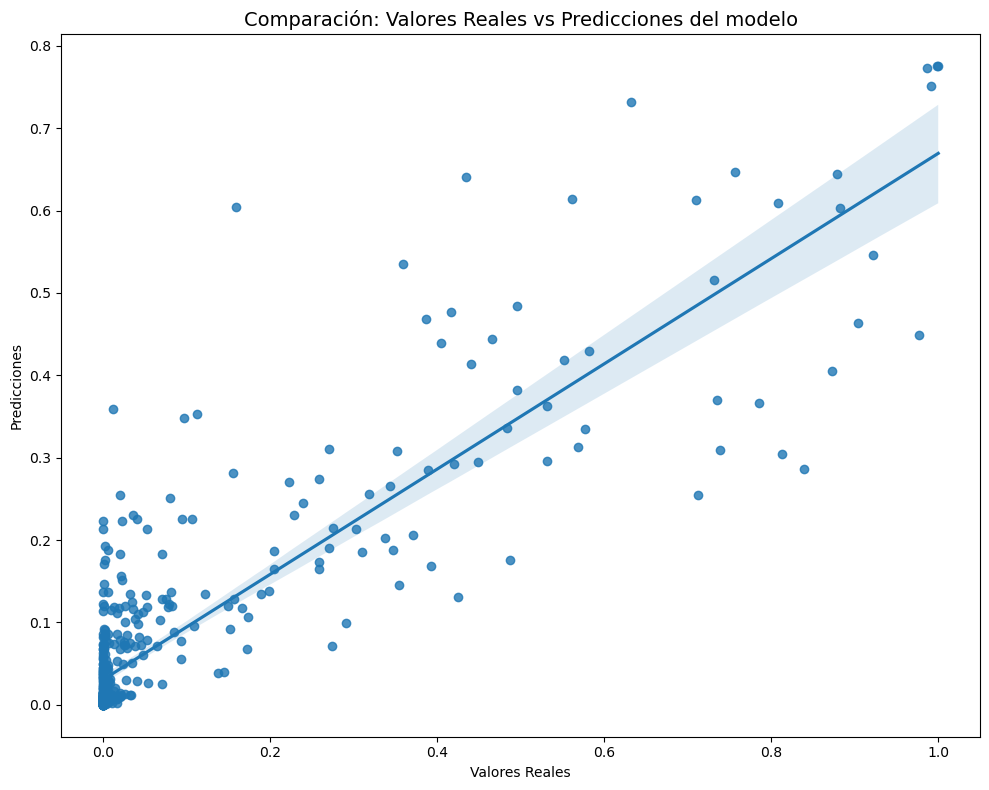

In [31]:
plotear_predvsreal(y_train, y_train_pred, tamanio= (10,8))

De este gráfico podemos resaltar los siguientes detalles:

* A valores bajos de los valores reales parece **no haber tanta incertidumbre**, suponemos que es poque es más sencillo predecir una proporción baja de votos
* Luego **a valores altos si aumenta la incertidumbre**, comportamiento que esperamos sea **"normal"** pero también es interesante ver como en algunos puntos se ajusta casi de manera 
  precisa
* Las predicciones **no se ajustaron demasiado al valor real**, suponemos que por el ruido en los datos o algún patrón que nuestro modelo no capta. Sin embargo no está del todo
  mal ya que nos hace saber que **tampoco hubo un grave sobreajuste**

También resulta interesante ver el **nivel de importancia** que le dió nuestro modelo a cada feature, vamos a visualizacrlo:

<Axes: xlabel='Feature'>

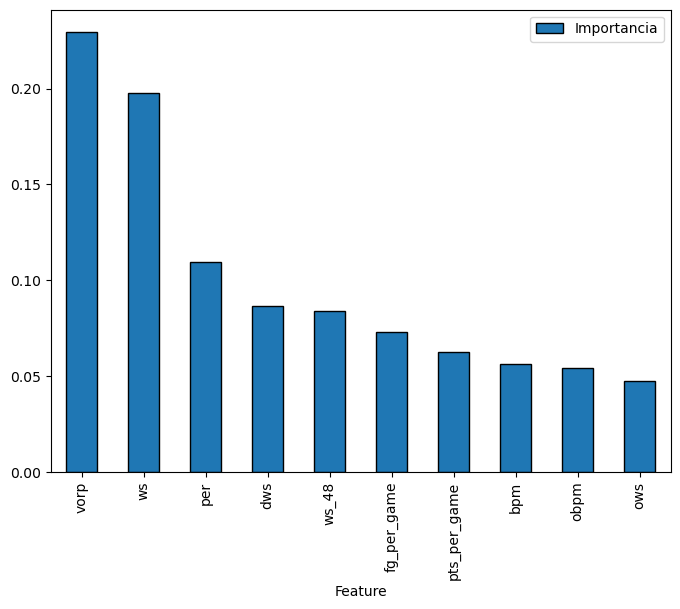

In [24]:
importancia = calcular_importancia(set_entrenamiento= X_train, modelo= forest_reg)

importancia.plot(x='Feature', y='Importancia', kind='bar', figsize=(8, 6), edgecolor='black')

Estos valores de importancia que el modelo dió a cada feature era de esperarse y **hace sentido** con lo que dijimos 
en la parte del análisis exploratorio. Entre los aspectos más importantes podemos resaltar que:

* 'vorp' **(Value over Replacement Player)** fue la feature que pisó más fuerte, hay que recordar que esta columna media de algún modo "la falta que hacía el jugador cuando alguien lo reemplazaba"
*  En segundo y tercer lugar tenemos a 'ws' **(Win Shares)** y el **PER**, las cuales del mismo modo habíamos visto que tenían alta correlación con la variable objetivo, pero además es interesante destacar como el modelo le dió más importancia a los **Win Shares** que recordemos media **la proporción de la victoria del equipo que le correspondía al jugador**
* Luego el resto de features se distribuyen de forma bastante similar pero siempre con un grado de importancia no insignificante, lo que indica que **cada una aportó positivamente al modelo** y no elegimos features redundantes

## Métricas: **Armando podios**

Finalmente, una **"métrica"** que se ajusta bastante bien a nuestro problema consiste en lo siguiente:

* Tomar las predicciones hechas por el modelo y observar **temporada por temporada**
* Ver que el modelo **ubique correctamente a los jugadores** en el podio, para nuestro problema nos importa más ese aspecto
  a que indique la proporción de votos con total precisión


In [11]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2011, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
43,2011,Derrick Rose,0.977,0.449588
157,2011,Dwight Howard,0.531,0.362660
210,2011,Dwyane Wade,0.020,0.183534
294,2011,Kobe Bryant,0.354,0.145110
85,2011,Kevin Durant,0.157,0.128567


In [12]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2014, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
82,2014,Kevin Durant,0.986,0.773518
89,2014,Kevin Love,0.020,0.254256
12,2014,Blake Griffin,0.347,0.187772
186,2014,Joakim Noah,0.258,0.164455
136,2014,Stephen Curry,0.053,0.118482


In [13]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2016, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
134,2016,Stephen Curry,1.000,0.775175
80,2016,Kevin Durant,0.112,0.352485
73,2016,Kawhi Leonard,0.484,0.335573
123,2016,Russell Westbrook,0.371,0.205910
20,2016,Chris Paul,0.082,0.120121


In [14]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2017, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
122,2017,Russell Westbrook,0.879,0.643949
72,2017,Kawhi Leonard,0.495,0.382496
162,2017,Isaiah Thomas,0.080,0.250526
4,2017,Anthony Davis,0.002,0.193252
79,2017,Kevin Durant,0.002,0.176154


De esta evaluación resaltamos lo siguiente:

* Aunque existe cierta diferencia entre **'mvp_share'** y **'y_pred'**, nuestro modelo **logró acertar al ganador del premio en cada temporada**
* Hay que recordar que hay **5 jugadores los cuales fueron sacados del conjunto de entrenamiento**, por lo tanto es normal que en sus años de ganar el premio
  el modelo los cambie por otro jugador
* Hay que recordar que esto **recién es el entrenamiento**, la prueba real se realizará en los datos de prueba, sin embargo estos resultados nos van dejando ver las capacidades de nuestro modelo

A continuación dejamos una tabla con los últimos ganadores para que puedan verificar a [los últimos ganadores](https://www.hispanosnba.com/historia/premios/mvp-nba):

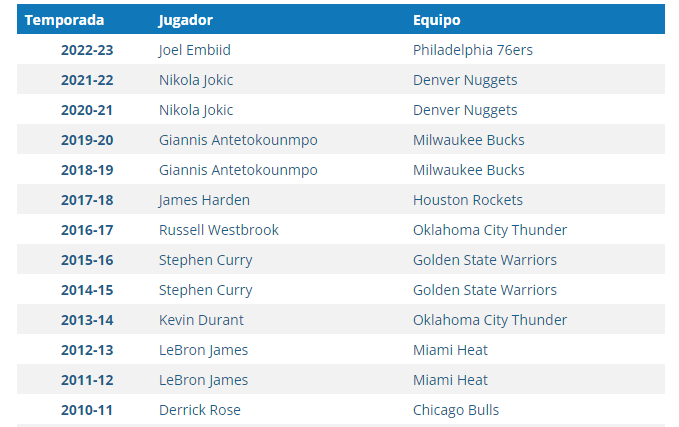

Finalmente, guardamos el modelo y el pipeline para ir a la **prueba final**:

In [15]:
dump(forest_reg, data_dir("for_modeling", "forest_reg.joblib"))
dump(pip, data_dir("for_modeling", "pipeline.joblib"))

['/home/gerardo19/proyecto_nba_mvp/data/for_modeling/pipeline.joblib']